In [2]:
import pandas as pd
import numpy as np
import pyodbc
import matplotlib.pyplot as plt
import seaborn as sns

### Connection - SQL SERVER

In [3]:
server = 'Henrique'
database = 'WideWorldImportersDW'
conexao = pyodbc.connect(
                'DRIVER={ODBC Driver 17 for SQL Server};'
                f'SERVER={server};'
                f'DATABASE={database};'
                'Trusted_Connection=yes;'
)


In [4]:
with open(r'C:\Users\pichau\Desktop\WideWorld\sql\02_exploracao.sql', 'r', encoding='utf-8') as file:
    query = file.read()

df = pd.read_sql(query, conexao)
df.to_csv(r'C:\Users\pichau\Desktop\WideWorld\docs\exports\orders_data.csv', sep=',', decimal='.', encoding='utf-8')

C:\Users\pichau\AppData\Local\Temp\ipykernel_8836\3727615342.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conexao)


### ETL - Data Preparation

In [5]:
df.info()
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.isnull().sum()
df.duplicated().sum()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231412 entries, 0 to 231411
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Order Key            231412 non-null  int64  
 1   Customer Key         231412 non-null  int64  
 2   Quantity             231412 non-null  int64  
 3   Unit Price           231412 non-null  float64
 4   Total Excluding Tax  231412 non-null  float64
 5   Total Including Tax  231412 non-null  float64
 6   City                 231412 non-null  object 
 7   State Province       231412 non-null  object 
 8   Customer             231412 non-null  object 
 9   Date                 231412 non-null  object 
 10  Month                231412 non-null  object 
 11  Short Month          231412 non-null  object 
 12  Month_Number         231412 non-null  int64  
 13  Year                 231412 non-null  int64  
dtypes: float64(3), int64(5), object(6)
memory usage: 24.7+ MB


,order_key,customer_key,quantity,unit_price,total_excluding_tax,total_including_tax,month_number,year
count,231412.000000,231412.000000,231412.000000,231412.000000,231412.000000,231412.000000,231412.000000,231412.000000
mean,115706.500000,126.922627,40.235182,45.207066,767.610480,882.505295,6.092420,2014.307469
std,66803.034584,133.921762,55.138491,138.949335,1446.640756,1663.534137,3.425604,1.002111
min,1.000000,0.000000,1.000000,0.660000,2.500000,2.880000,1.000000,2013.000000
25%,57853.750000,0.000000,5.000000,13.000000,96.000000,110.400000,3.000000,2013.000000
50%,115706.500000,84.000000,10.000000,18.000000,240.000000,276.000000,6.000000,2014.000000
75%,173559.250000,243.000000,60.000000,32.000000,888.000000,1021.200000,9.000000,2015.000000
max,231412.000000,402.000000,360.000000,1899.000000,18990.000000,21838.500000,12.000000,2016.000000


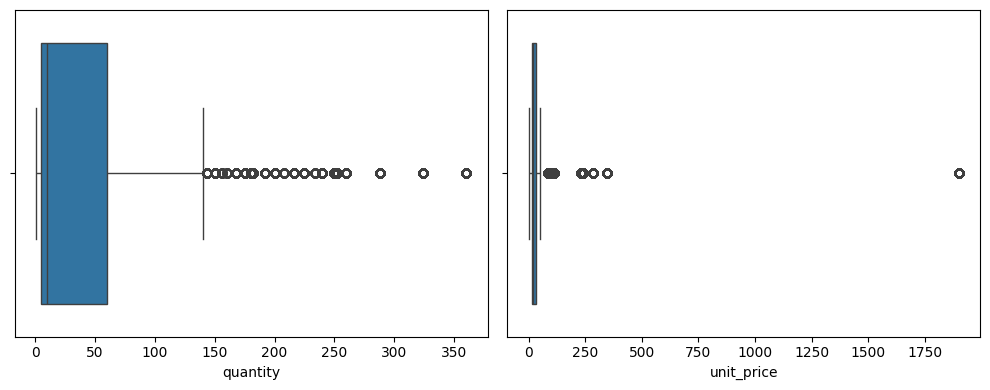

In [6]:
# Identificando Outliers
columns_outliers = ['quantity', 'unit_price']

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes = axes.flatten()
for i, c in enumerate(columns_outliers):
    sns.boxplot(x=df[c], ax=axes[i])

plt.tight_layout()
plt.show()

In [7]:
df['date'] = pd.to_datetime(df['date'])

In [8]:
df['company'] = df['customer'].str.split('(', expand=True)[0].str.strip()
df['state_code'] = df['customer'].str.split('(',expand=True)[1].str.split(',', expand=True)[1].str.replace(')', '').str.strip()
df['state_code']

0           PA
1           PA
2           PA
3           PA
4           PA
          ... 
231407    None
231408      AL
231409    None
231410      OR
231411      OR
Name: state_code, Length: 231412, dtype: object

In [9]:
df['state_province'] = df['state_province'].str.replace('[E]', '')

### EDA - Exploratory Data Analysis

In [10]:
# Correlações
num_cols = df.select_dtypes(include='number')

num_cols.corr()

,order_key,customer_key,quantity,unit_price,total_excluding_tax,total_including_tax,month_number,year
order_key,1.000000,-0.022579,0.008572,-0.002700,0.002674,0.002450,0.060859,0.959062
customer_key,-0.022579,1.000000,0.000986,-0.002665,0.001072,0.001069,-0.003849,-0.020724
quantity,0.008572,0.000986,1.000000,-0.137220,0.234954,0.234655,-0.004651,0.009294
unit_price,-0.002700,-0.002665,-0.137220,1.000000,0.528453,0.528524,0.004660,-0.003888
total_excluding_tax,0.002674,0.001072,0.234954,0.528453,1.000000,0.999997,-0.001776,0.003171
total_including_tax,0.002450,0.001069,0.234655,0.528524,0.999997,1.000000,-0.001646,0.002921
month_number,0.060859,-0.003849,-0.004651,0.004660,-0.001776,-0.001646,1.000000,-0.221208
year,0.959062,-0.020724,0.009294,-0.003888,0.003171,0.002921,-0.221208,1.000000


Análise Geral - Gasto/Pedido

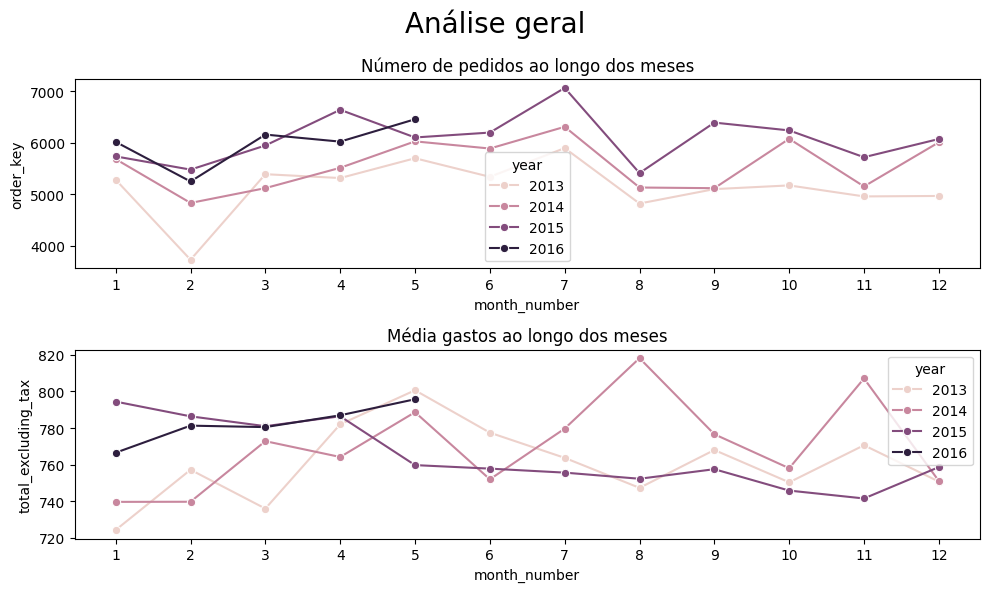

In [11]:
grouped = df.groupby(['year','month_number'])[['order_key','total_excluding_tax']].agg({'order_key':'count','total_excluding_tax':'mean'}).reset_index()

fig, axes = plt.subplots(2,  figsize=(10, 6))
plt.suptitle('Análise geral', size=20)
sns.lineplot(data=grouped, x='month_number', y='order_key', hue='year', ax=axes[0], marker='o')
axes[0].set_title('Número de pedidos ao longo dos meses')
axes[0].set_xticks(np.arange(1, 13))

sns.lineplot(data=grouped, x='month_number', y='total_excluding_tax', hue='year', ax=axes[1], marker='o')
axes[1].set_title('Média gastos ao longo dos meses')
axes[1].set_xticks(np.arange(1, 13))

plt.tight_layout()
plt.show()



- O volume de pedidos cresce ano a ano com picos em julho, apesar do recuo constante em fevereiro. Já o ticket médio é instável: enquanto os pedidos bateram recorde em 2015, a média de gasto caiu, indicando que as empresas passaram a vender mais vezes, porém em valores menores.


Análise - Gasto/Pedido por Empresa

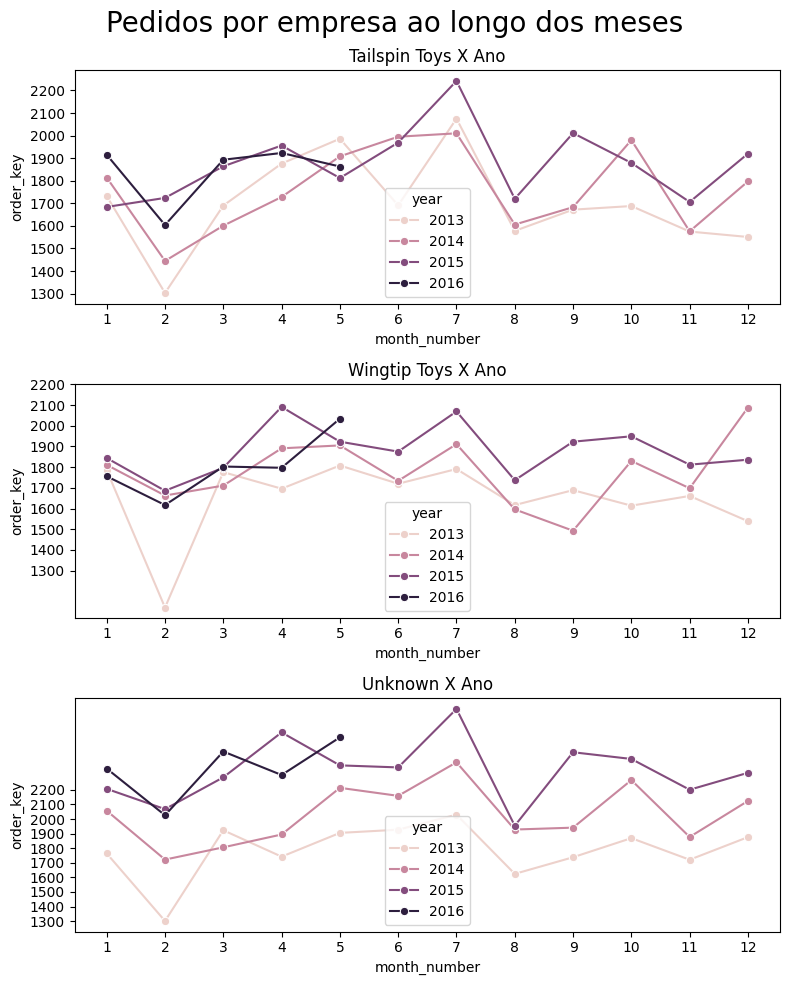

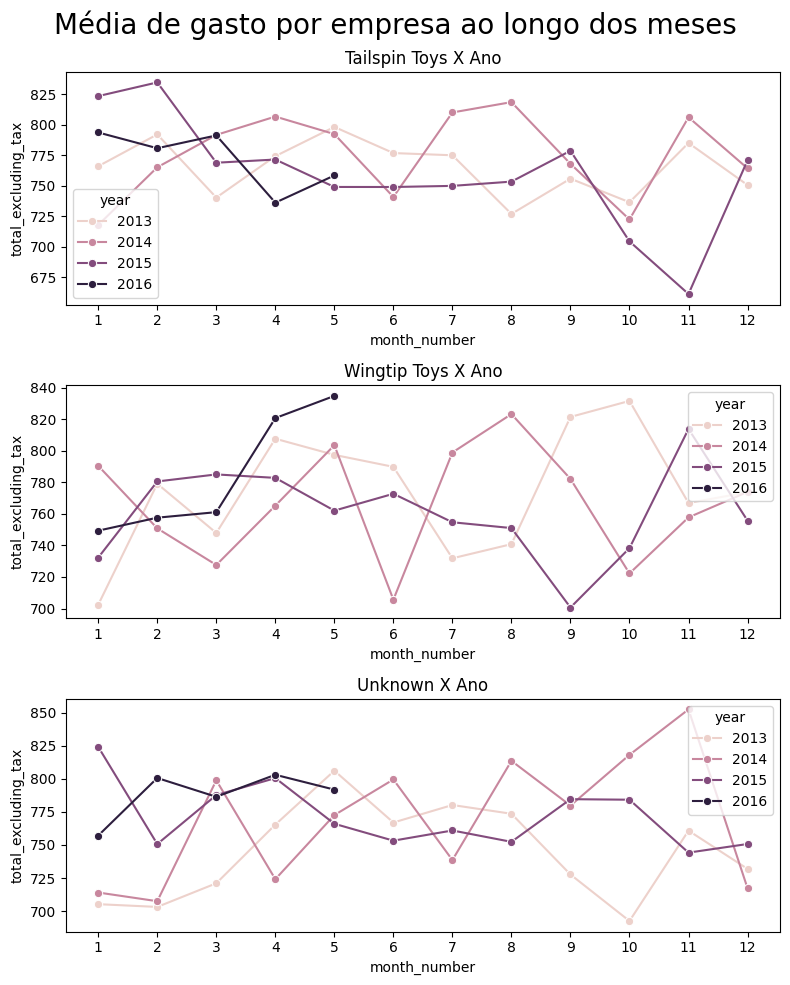

In [12]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10))
plt.suptitle('Pedidos por empresa ao longo dos meses', size=20)
customer_temp = df.groupby(['company','year','month_number'])[['order_key', 'total_excluding_tax']].agg({'order_key':'count', 'total_excluding_tax':'mean'}).reset_index()

for i, company in enumerate(['Tailspin Toys', 'Wingtip Toys', 'Unknown']):
    company_temp = customer_temp[customer_temp['company'] == company]
    sns.lineplot(data=company_temp, x='month_number', y='order_key', hue='year', ax=axes[i], marker='o')
    axes[i].set_title(f'{company} X Ano')
    axes[i].set_xticks(np.arange(1, 13))
    axes[i].set_yticks(np.linspace(1300, 2200, 10))

plt.tight_layout()
plt.show()



fig, axes = plt.subplots(3, 1, figsize=(8, 10))
plt.suptitle('Média de gasto por empresa ao longo dos meses', size=20)

for i, company in enumerate(['Tailspin Toys', 'Wingtip Toys', 'Unknown']):
    company_temp = customer_temp[customer_temp['company'] == company]
    sns.lineplot(data=company_temp, x='month_number', y='total_excluding_tax', hue='year', ax=axes[i], marker='o')
    axes[i].set_title(f'{company} X Ano')
    axes[i].set_xticks(np.arange(1, 13))

plt.tight_layout()
plt.show()

Pedidos
- O volume de pedidos cresce anualmente em todas as frentes, com um pico sazonal em julho e queda em agosto.


Análise - Gasto/Pedido por Estado


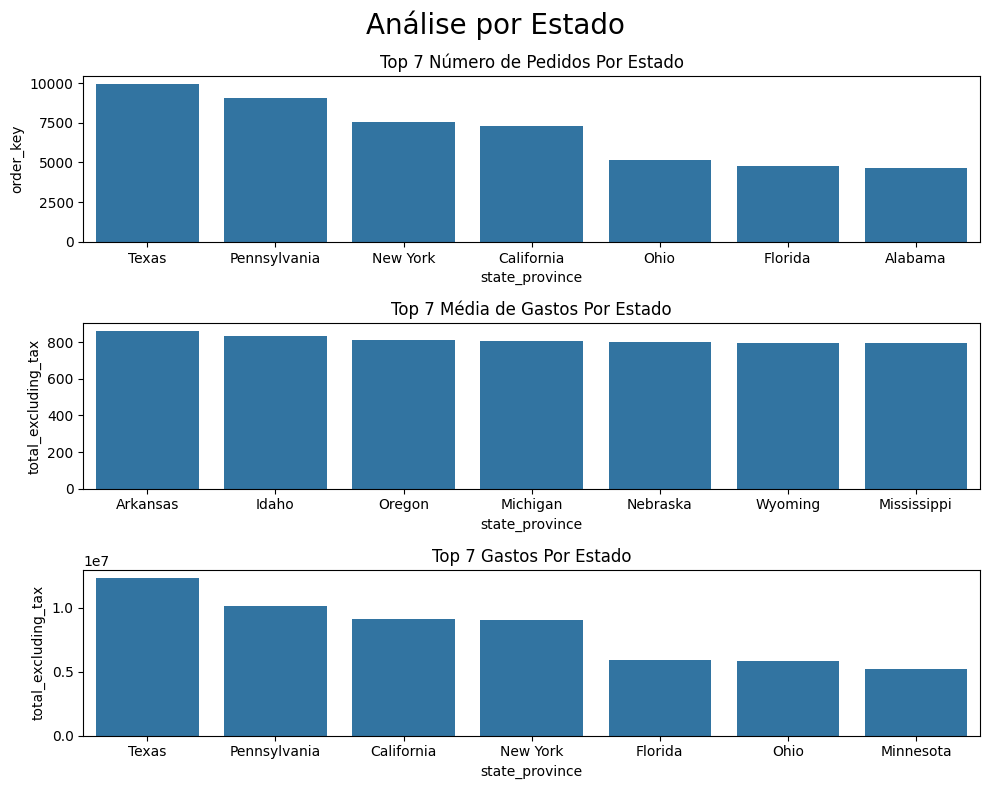

,state_province,total_excluding_tax
41,Texas,12328671.15
36,Pennsylvania,10098891.90
4,California,9150598.05
30,New York,9011425.55
7,Florida,5941272.40
33,Ohio,5853741.10
21,Minnesota,5229183.95


In [13]:
filter_state = df[df['company'] != 'Unknown']
state_grouped = filter_state.groupby('state_province')[['order_key', 'total_excluding_tax']].agg({'order_key':'count', 'total_excluding_tax':'mean'}).reset_index()
fig, axes = plt.subplots(3, figsize=(10, 8))

plt.suptitle('Análise por Estado', size=20)

state_top7 = state_grouped.sort_values(by='order_key', ascending=False).head(7)
sns.barplot(data=state_top7, x='state_province', y='order_key', ax=axes[0])
axes[0].set_title('Top 7 Número de Pedidos Por Estado')


state_top7 = state_grouped.sort_values(by='total_excluding_tax', ascending=False).head(7)
sns.barplot(data=state_top7, x='state_province', y='total_excluding_tax', ax=axes[1])
axes[1].set_title('Top 7 Média de Gastos Por Estado')

state_top7 = df.groupby('state_province')['total_excluding_tax'].sum().reset_index().sort_values(by='total_excluding_tax', ascending=False).head(7)
sns.barplot(data=state_top7, x='state_province', y='total_excluding_tax', ax=axes[2])
axes[2].set_title('Top 7 Gastos Por Estado')

plt.tight_layout()
plt.show()

state_top7

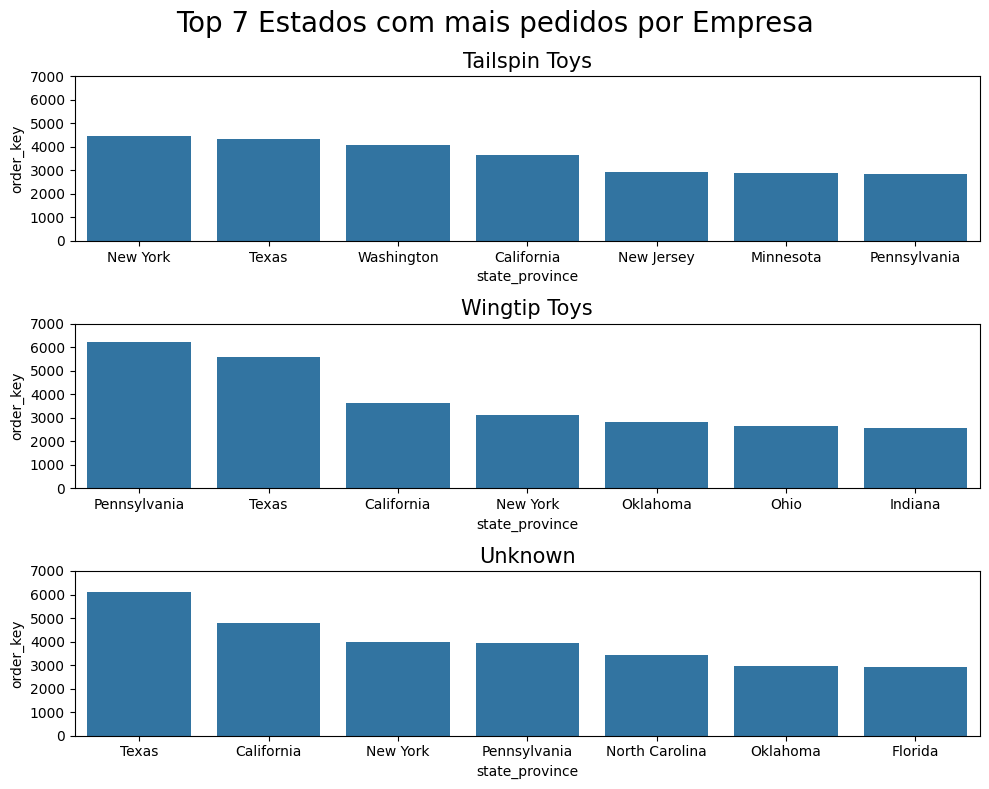

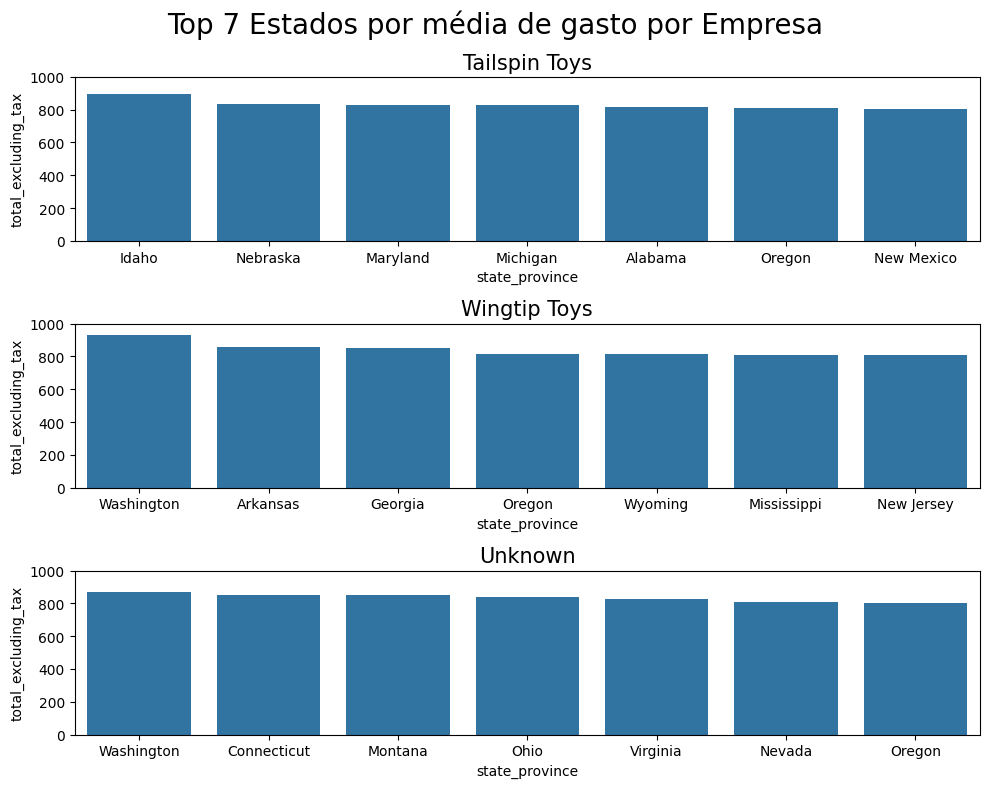

In [14]:
company_grouped = df.groupby(['company', 'state_province'])[['order_key', 'total_excluding_tax']].agg({'order_key':'count', 'total_excluding_tax':'mean'}).reset_index()
fig, axes = plt.subplots(3, figsize=(10, 8))
plt.suptitle('Top 7 Estados com mais pedidos por Empresa', size=20)
for i, company in enumerate(['Tailspin Toys', 'Wingtip Toys', 'Unknown']):
    company_state_top7 = company_grouped[company_grouped['company'] == company]
    company_state_top7 = company_state_top7.sort_values(by='order_key', ascending=False).head(7)
    sns.barplot(data=company_state_top7, x='state_province', y='order_key', ax=axes[i])
    axes[i].set_title(f'{company}', size=15)
    axes[i].set_yticks(np.arange(0, 8000, 1000))

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(3, figsize=(10, 8))
plt.suptitle('Top 7 Estados por média de gasto por Empresa', size=20)
for i, company in enumerate(['Tailspin Toys', 'Wingtip Toys', 'Unknown']):
    company_state_top7 = company_grouped[company_grouped['company'] == company]
    company_state_top7 = company_state_top7.sort_values(by='total_excluding_tax', ascending=False).head(7)
    sns.barplot(data=company_state_top7, x='state_province', y='total_excluding_tax', ax=axes[i])
    axes[i].set_title(f'{company}', size=15)
    axes[i].set_yticks(np.arange(0, 1100, 200))

plt.tight_layout()
plt.show()

In [15]:
df['is_unknown'] = (df['company'] == 'Unknown').astype(int)

In [16]:
company_grouped_year = pd.pivot_table(df, index=['company', 'month_number'], columns='year', values='order_key', aggfunc='count').fillna(0)

df['is_unknown'].mean() * 100

round(df['total_excluding_tax'].sum(), 2)

df[df['is_unknown'] == 1]['total_excluding_tax'].sum()
df[df['company'] == 'Tailspin Toys']['total_excluding_tax'].sum()
df[df['company'] == 'Wingtip Toys']['total_excluding_tax'].sum()

55916718.8

Gerando CSV

In [17]:
#Gerando CSV com dados temporais agrupando por empresa
caminho = r'C:\Users\pichau\Desktop\WideWorld\docs\exports\\'

df_temp = df.groupby(['company', 'year', 'month_number']).agg(orders_count=('order_key','count'), total_spent=('total_excluding_tax','sum'), avg_spent=('total_excluding_tax','mean')).reset_index()

df_temp['avg_spent'] = round(df_temp['avg_spent'], 2)

df_temp['is_unknown'] = np.where(df_temp['company'] == 'Unknown', 1, 0)

df_temp['data'] = pd.to_datetime(df_temp['year'].astype(str) + '-' + df_temp['month_number'].astype(str) + '-01')

df_temp['data'] = df_temp['data'].dt.strftime('%d/%m/%Y')

meses_pt = {1:'Janeiro', 2:'Fevereiro', 3:'Março', 4:'Abril', 5:'Maio', 6:'Junho',
            7:'Julho', 8:'Agosto', 9:'Setembro', 10:'Outubro', 11:'Novembro', 12:'Dezembro'}
df_temp['Mes'] = df_temp['month_number'].map(meses_pt)

novos_nomes = {
    'company': 'empresa',
    'year': 'ano',
    'month_number': 'mes_numero',
    'orders_count': 'pedidos',
    'total_spent': 'total_gasto',
    'avg_spent': 'media_gasto',
    'is_unknown': 'empresa_desconhecida'
}

df_temp.rename(columns=novos_nomes, inplace=True)


df_temp.to_csv(f'{caminho}company_temp.csv', index=False, encoding='utf-8', sep=';', decimal=',')

In [18]:
# Gerando CSV Com dados Temporais agrupando por ano, empresa e estado

filter_df = df[df['company'] != 'Unknown']

df_company_state = filter_df.groupby(['year', 'company', 'state_province', 'state_code', 'city']).agg(orders_count=('order_key', 'count'), total_spent=('total_excluding_tax', 'sum'), avg_spent=('total_excluding_tax', 'mean'), months_count=('month_number', 'unique')).reset_index()

df_company_state['avg_spent'] = round(df_company_state['avg_spent'], 2)

df_company_state['ano_completo'] = (
    df_company_state['months_count'].apply(lambda x: 1 if len(x) == 12 else 0)
)


df_company_state.drop(columns='months_count', inplace=True)

df_company_state = df_company_state.rename(columns={
    'year': 'ano',
    'company': 'empresa',
    'state_code':'sigla_estado',
    'city':'cidade',
    'state_province': 'estado',
    'orders_count': 'qtd_pedidos',
    'total_spent': 'total_gasto',
    'avg_spent': 'gasto_medio',
})


df_company_state.to_csv(f'{caminho}company_state.csv', index=False, encoding='utf-8', sep=';', decimal=',')